In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
bank_data = pd.read_csv('bank-full.csv', sep=';')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Machine Learning Phase

- Categorical  Encodings

In [3]:
from sklearn.preprocessing import LabelEncoder
df = bank_data.copy()

for col in df.select_dtypes('object'):
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

- Here we check the Multi-colinearity between the columns
- nr.employed, cons.price.idx, euribor3m, pdays, cons.conf.idx	Those columns have very high VIF and this suggests that we should drop (nr.employed, euribor3m)

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
19,nr.employed,44301.582935
16,cons.price.idx,38881.736440
18,euribor3m,333.532385
12,pdays,166.369670
17,cons.conf.idx,131.859364
15,emp.var.rate,40.727910
14,poutcome,34.178782
0,age,19.748825
8,month,6.844007
13,previous,5.964609


- There are some Outliers in our columns we will try to detect them Using The IQR method

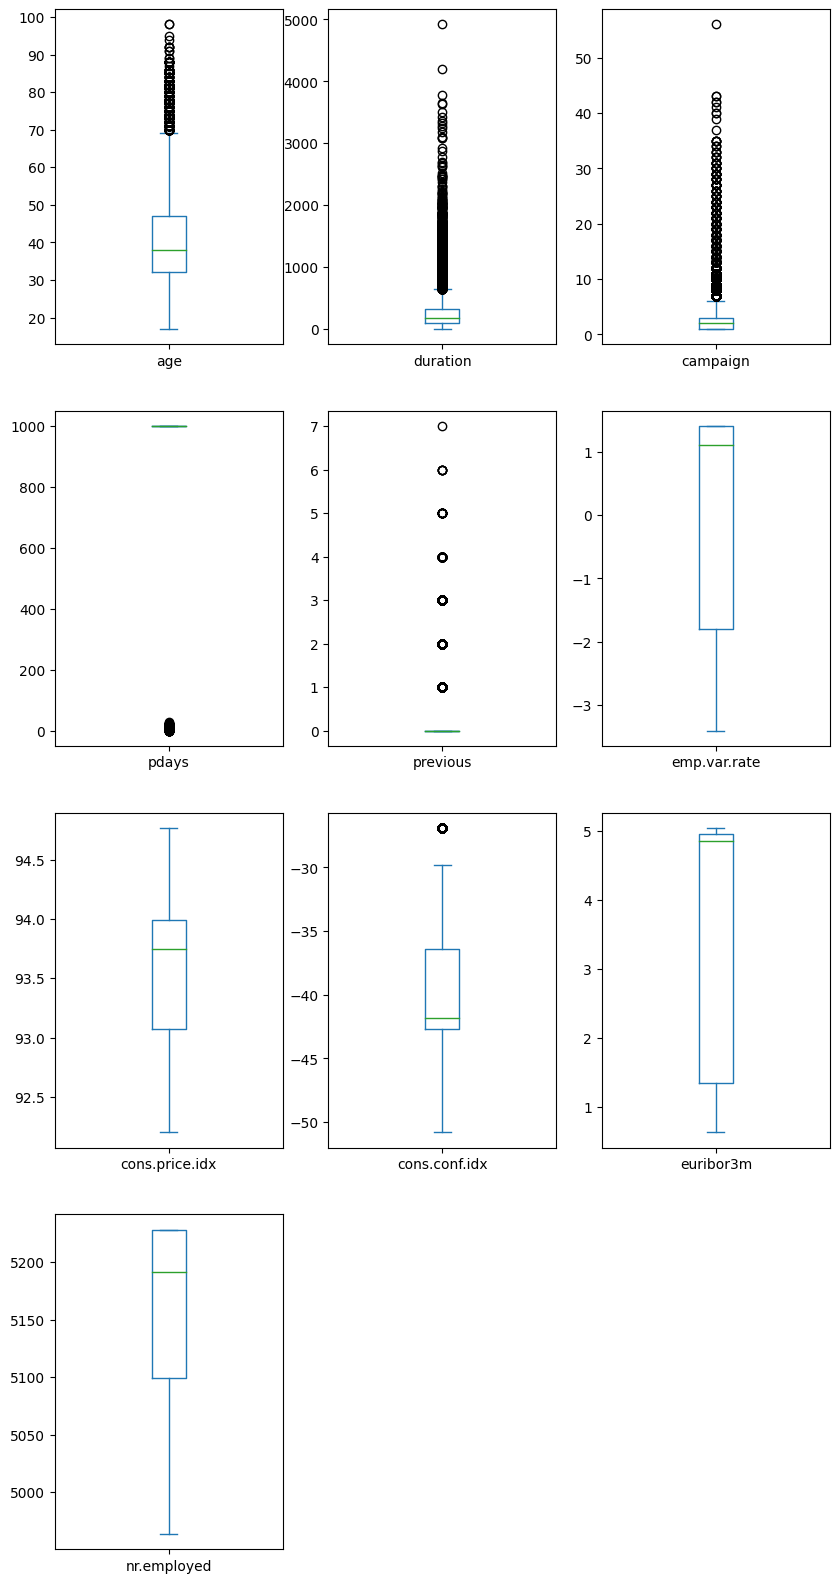

In [5]:
numerical_data = bank_data.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(10, 20),  layout=(4, 3))

plt.savefig('figs/Box Plots.png', format='png')

- Getting the indecies of the outliers. I can't Drop all the outliers because the it contains 190 y-yes values so we may drop the y-no rows but keeping the y-yes rows.

In [6]:
q3, q1 = np.percentile(df['cons.conf.idx'], [75, 25])
print(q3, q1)
print(len(df))

IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

-36.4 -42.7
41188
6.300000000000004


In [7]:
mask1 = df['cons.conf.idx'] > upper_bound
mask2 = df['cons.conf.idx'] < lower_bound

outliers_indecies = df[(mask1) | (mask2)].index

len(outliers_indecies)

447

In [8]:
df.loc[outliers_indecies]['y'].value_counts()

0    267
1    180
Name: y, dtype: int64

In [9]:
df.corr()['y']

age               0.030399
job               0.025122
marital           0.046203
education         0.057799
default          -0.099352
housing           0.011552
loan             -0.004909
contact          -0.144773
month            -0.006065
day_of_week       0.015967
duration          0.405274
campaign         -0.066357
pdays            -0.324914
previous          0.230181
poutcome          0.129789
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
y                 1.000000
Name: y, dtype: float64

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
19,nr.employed,44301.582935
16,cons.price.idx,38881.736440
18,euribor3m,333.532385
12,pdays,166.369670
17,cons.conf.idx,131.859364
15,emp.var.rate,40.727910
14,poutcome,34.178782
0,age,19.748825
8,month,6.844007
13,previous,5.964609


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['nr.employed', 'cons.price.idx', 'euribor3m', 'pdays',\
    'cons.conf.idx', 'emp.var.rate', 'poutcome', 'age']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
0,nr.employed,26545.034267
1,cons.price.idx,22213.821450
2,euribor3m,225.107808
4,cons.conf.idx,120.340068
3,pdays,47.148813
5,emp.var.rate,28.753677
7,age,16.042932
6,poutcome,11.548398


- Handling the imbalanced target variable.

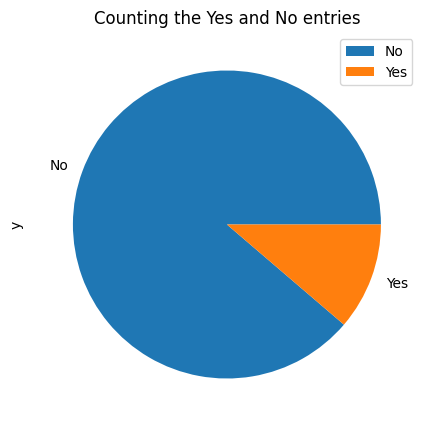

In [12]:
df['y'].value_counts().plot.pie(labels=['No', 'Yes'], figsize=(10, 5))
plt.legend()
plt.title('Counting the Yes and No entries')
plt.savefig('figs/Counting the Yes and No entries.png', format='png')
plt.show()

In [13]:
from imblearn.over_sampling import RandomOverSampler

X =  df.drop(['nr.employed', 'cons.price.idx', 'euribor3m',\
    'cons.conf.idx', 'emp.var.rate', 'y'], axis=1)
y = df['y']

rus = RandomOverSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)

-  After  the random under sampling

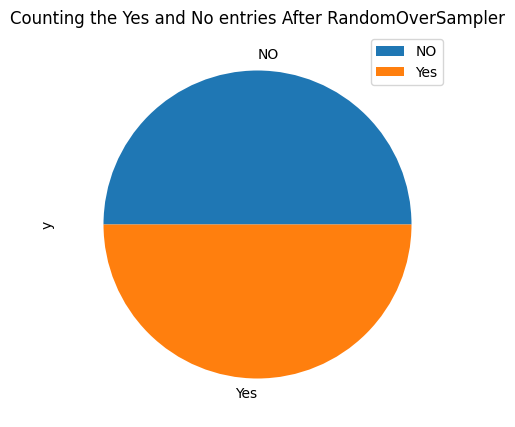

In [14]:
y_res.value_counts().plot.pie(labels=['NO', 'Yes'], figsize=(10, 5))
plt.legend()
plt.title('Counting the Yes and No entries After RandomOverSampler')
plt.savefig('figs/Counting the Yes and No entries After RandomOverSampler.png', format='png')
plt.show()

- Those columns have higher VIF, I tested them and found out that the model does better without them.

Knn 0.9070126530799779 0.002458625159214045
Dtc 0.9617625919981764 0.0019029846310615393
Rdf 0.9710654387984679 0.0010878474963499222
adb 0.842139117908604 0.003821374584381845
grdb 0.863056798168229 0.003233295974889429
Gaus 0.7170433357485325 0.0027738468421555145
LDA 0.7918491180779768 0.0026120343878950633
LogR 0.8047635916716892 0.003212174479953477


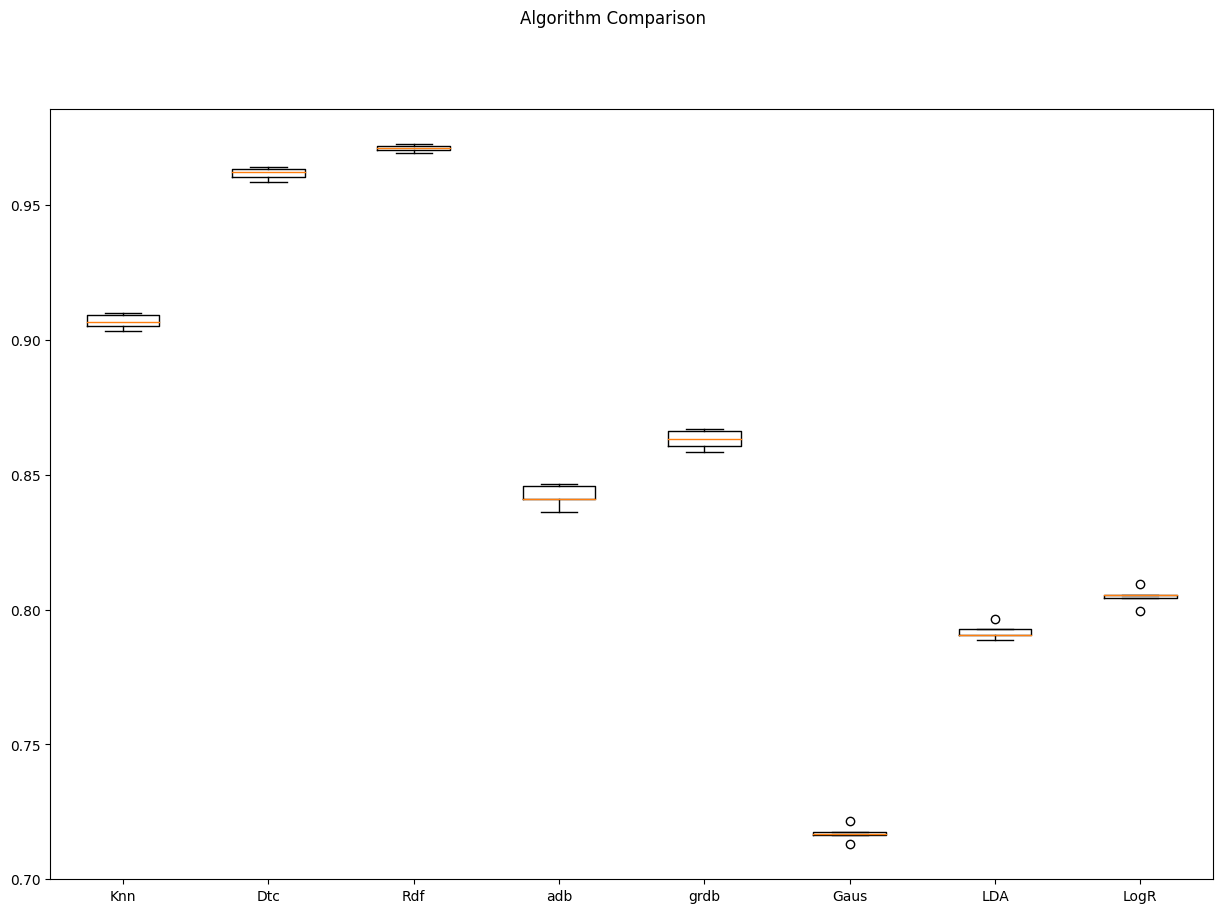

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsClassifier()),
    # ('svc', SVC()),
    ('Dtc', DecisionTreeClassifier()),
    ('Rdf', RandomForestClassifier()),
	('adb', AdaBoostClassifier()),
    ('grdb', GradientBoostingClassifier()),
    ('Gaus', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('LogR', LogisticRegression(max_iter=1000)),
    # ('MLP', MLPClassifier(max_iter=1000))
]
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_res, y_res, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean(), cv_results.std())
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=0)

model = RandomForestClassifier()

model.fit(X_train, y_train)
pred = model.predict(X_test)

In [17]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[3333  181]
 [   0 3796]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      3514
           1       0.95      1.00      0.98      3796

    accuracy                           0.98      7310
   macro avg       0.98      0.97      0.98      7310
weighted avg       0.98      0.98      0.98      7310

Area Under Curve : 
 0.9742458736482641


In [18]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [19]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9752393980848153
